# Code for image generation using VAE

### Getting started with Generative Models
### ---- Nikhil Mehta ----

In [17]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(22301)
tf.set_random_seed(0)

## Load Dataset

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Xavier weight initialization using fan_in and fan_out trick as mentioned in "Understanding the difficulty of training deep feedforward neural networks"


In [19]:
def xavier_init(fan_in, fan_out, constant=1):
    
    low = -constant * np.sqrt(6.0/(fan_in + fan_out))
    high = constant * np.sqrt(6.0/(fan_in + fan_out))

    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high,
                            dtype=tf.float32)

In [28]:
class VariationalAutoencoder(object):
    """Auto-Encoding Variational Bayes by Kingma and Welling"""
    
    def __init__(self, network, transfer_function=tf.nn.softplus,
                learning_rate=0.001, batch_size=100):
            
            self.network = network
            self.transfer_function=tf.nn.softplus
            self.learning_rate = learning_rate
            self.batch_size = batch_size
            
            # input
            self.x = tf.placeholder(tf.float32, 
                                    [None, network["n_input"]])
            
            # create autoencoder network
            self._create_network()
            
            # Define loss function based variational upper-bound
            self._create_loss_optimizer()
            
            init = tf.global_variables_initializer()
            
            self.sess = tf.InteractiveSession()
            self.sess.run(init)
    
    def _initialize_weights(self, n_recog_h1, n_recog_h2,
                           n_gener_h1, n_gener_h2,
                           n_input, n_z):
        
        network_weights = dict()
    
        network_weights['weights_recog'] = {
            'h1' : tf.Variable(xavier_init(n_input, n_recog_h1)),
            'h2' : tf.Variable(xavier_init(n_recog_h1, n_recog_h2)),
            
            'z_mean' : tf.Variable(xavier_init(n_recog_h2, n_z)),
            'z_log_sigma' : tf.Variable(xavier_init(n_recog_h2, n_z)),
        }
    
        network_weights['biases_recog'] = {
            'b1' : tf.Variable(tf.zeros([n_recog_h1], dtype=tf.float32)),
            'b2' : tf.Variable(tf.zeros([n_recog_h2], dtype=tf.float32)),
            
            'z_mean' : tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'z_log_sigma' : tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
    
        network_weights['weights_gener'] = {
            'h1' : tf.Variable(xavier_init(n_z, n_gener_h1)),
            'h2' : tf.Variable(xavier_init(n_gener_h1, n_gener_h2)),
            
            'out_mean' : tf.Variable(xavier_init(n_gener_h2, n_input)),
            'out_log_sigma' : tf.Variable(xavier_init(n_gener_h2, n_input))
        }
        
        network_weights['biases_gener'] = {
            'b1' : tf.Variable(tf.zeros([n_gener_h1], dtype=tf.float32)),
            'b2' : tf.Variable(tf.zeros([n_gener_h2], dtype=tf.float32)),
            
            'out_mean' : tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma' : tf.Variable(tf.zeros([n_input], dtype=tf.float32))
        }
        
        return network_weights
    
    def _recognize_network(self, weights, biases):
        
        # Generate probabilistic encoder (recognition network), which maps
        # inputs onto a normal distribution in latent space. 
        # The transformation is parameterized and can be learned
        
        layer_1 = self.transfer_function(tf.add(tf.matmul(self.x, weights['h1']), 
                                                biases['b1']))
        layer_2 = self.transfer_function(tf.add(tf.matmul(layer_1, weights['h2']),
                                                biases['b2']))
        
        z_mean = tf.add(tf.matmul(layer_2, weights['z_mean']), biases['z_mean'])
        z_log_sigma = tf.add(tf.matmul(layer_2, weights['z_log_sigma']), biases['z_log_sigma'])
        
        return (z_mean, z_log_sigma)
    
    def _generator_network(self, weights, biases):
        
        # Gernerate probabilistic decoder which maps points in latent space onto a 
        # Bernoulli distribution in data space
        # The transformation is parameterized and can be learned
        # Note: Use Gaussian for images that are not in grey scale
        
        layer_1 = self.transfer_function(tf.add(tf.matmul(self.z, weights['h1']),
                                                biases['b1']))
        layer_2 = self.transfer_function(tf.add(tf.matmul(layer_1, weights['h2']), 
                                                biases['b2']))
    
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
    
        # x_reconst_sigma?
        
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
        
        # The loss is composed of 2 terms:
        
        # 1. The reconstruction loss (NLL) of the input under
        # the reconstruction under the Bernoulli distribution induced by the decoder 
        # in the data space
        
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) + 
                          (1-self.x) * tf.log(1e-10 + (1-self.x_reconstr_mean)), 
                           1)
            
            
        # 2. The latent loss, which is defined as the KL Diverg b/w the 
        # distr in latent space induced by the encoder and some prior.
        # This also acts a kind of regularizer
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq)
                                           ,1)
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        
        # Average over batch
        # Using Adam Optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
    
    def _create_network(self):
        
        # Initialize weights and biases
        network_weights = self._initialize_weights(**self.network)
                    
        # Use recognition network to determine mean and log variance 
        # of Gaussian distr for latent space    
        
        self.z_mean, self.z_log_sigma_sq = self._recognize_network(network_weights['weights_recog'], network_weights['biases_recog'])
        
        # Draw sample from z from Gaussian distribution
        n_z = self.network['n_z']
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        
        # z = mu+sigma*epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Use generator to determine mean of Bernoulli distribution
        # or reconstructed input
        
        self.x_reconstr_mean = self._generator_network(network_weights['weights_gener'],
                                    network_weights['biases_gener'])

    def partial_fit(self, X):
        # Train model based on mini-batch of input data.
        # Return cost of the function
        
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                 feed_dict={self.x:X})
        return cost
    
    
    def transform(self, X):
        
        # Transform data by mapping it into the latent space
        
        # This actually maps to mean of the distribution
        # We can sample from Gaussian if we want
        
        return self.sess.run(self.z_mean, feed_dict={self.x:X})
    
    def generate(self, z_mu=None):
        
        # Generates data from latent space
        # If z_mu is not None, data for this point 
        # in latent space is generated. Otherwise, z_mu is drawn 
        # from prior in latent space.

        if z_mu is None:
#             z_mu = np.random.normal(size=self.network['n_z'])
            z_mu = np.random.normal(size=(self.batch_size, self.network['n_z']))
        
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    

In [38]:
def train(network, learning_rate=0.001, batch_size=100, 
         training_epochs=10, display_step=5):
    
    vae = VariationalAutoencoder(network, learning_rate=learning_rate,
                               batch_size=batch_size)
    
    # Training Cycle
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int (n_samples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
        
            # Train for this batch
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost * batch_size / n_samples 
            
        # Display logs per epoch
        if epoch % display_step == 0:
            print ("Epoch: ", '%04d' % (epoch+1),
                  "cost: ", "{:.9f}".format(avg_cost))

    return vae

In [40]:
network = dict(n_recog_h1=500,
        n_recog_h2=500,
        n_gener_h1=500,
        n_gener_h2=500,
        n_input=784,
        n_z=20)
    
vae = train(network, training_epochs=75)


('Epoch: ', '0001', 'cost: ', '176.532172352')
('Epoch: ', '0006', 'cost: ', '109.728583235')
('Epoch: ', '0011', 'cost: ', '104.660596952')
('Epoch: ', '0016', 'cost: ', '102.420539454')
('Epoch: ', '0021', 'cost: ', '100.998565050')
('Epoch: ', '0026', 'cost: ', '99.949284266')
('Epoch: ', '0031', 'cost: ', '99.123524558')
('Epoch: ', '0036', 'cost: ', '98.408838640')
('Epoch: ', '0041', 'cost: ', '97.815391846')
('Epoch: ', '0046', 'cost: ', '97.193820898')
('Epoch: ', '0051', 'cost: ', '96.655091733')
('Epoch: ', '0056', 'cost: ', '96.254859578')
('Epoch: ', '0061', 'cost: ', '95.889636744')
('Epoch: ', '0066', 'cost: ', '95.542886561')
('Epoch: ', '0071', 'cost: ', '95.307620003')


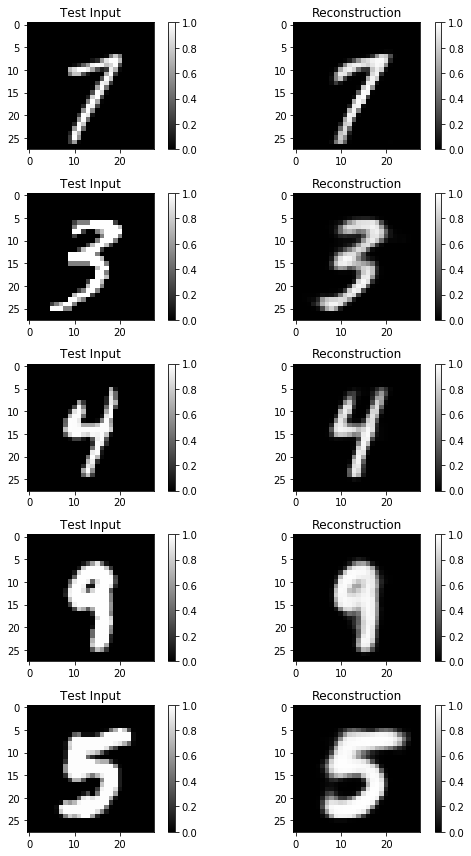

In [34]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8,12))
for i in range(5):
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

    

## Some Generated samples

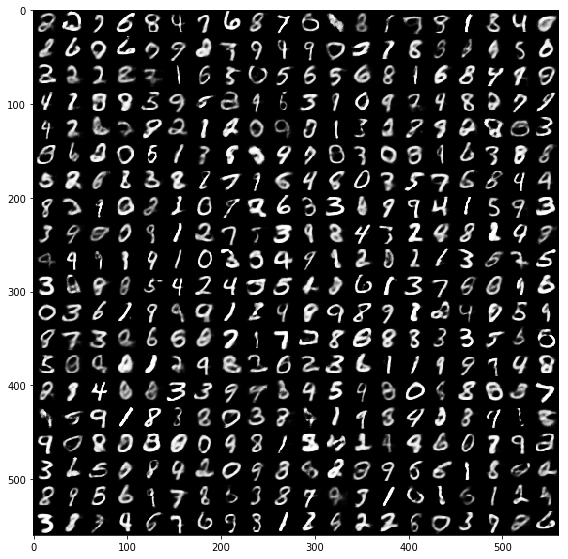

In [37]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
#         z_mu = np.array([[xi, yi]]*vae.batch_size)
#         x_mean = vae.generate(z_mu)
        x_mean = vae.generate()
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
